In [1]:
import gurobipy as gp
from gurobipy import GRB

In [4]:
import numpy as np

In [5]:
items_num = 100
items_weights = np.random.random(items_num)
# items_weights

In [63]:
def next_fit_1d(items):
    containers = []
    current_container_capacity = 1
    current_container_items = []
    for i in items:
        if i<=current_container_capacity:
            current_container_capacity-=i
            current_container_items.append(i)
        else:
            containers.append(current_container_items)
            current_container_items=[i]
            current_container_capacity=1-i
    return containers

res = next_fit_1d(items_weights)
len(res)

125

In [64]:
def first_fit_1d(items):
    containers = [[]]
    for i in range(len(items)):
        for c in containers:
            if sum([items_weights[j] for j in c])+items_weights[i] <=1:
                c.append(i)
                break
        else:
            containers.append([i])
        
    return containers

res_ff = first_fit_1d(items_weights)
len(res_ff)

102

In [65]:
def next_k_fit_1d(items, k=3):
    containers = [[]]
    for i in items:
        for c in containers[-k: ]:
            if sum(c)+i <=1:
                c.append(i)
                break
        else:
            containers.append([i])
    return containers

res = next_k_fit_1d(items_weights, 3)
len(res)

116

In [62]:
def worst_fit(items):
    containers = [[]]
    
    for i in items:
        min_container_id = 0
        for c_id in range(len(containers)):
            if sum(containers[c_id]) < sum(containers[min_container_id]):
                min_container_id = c_id
        if sum(containers[min_container_id])+i<=1:
            containers[min_container_id].append(i)
        else:
            containers.append([i])
    return containers

wf = worst_fit(items_weights)
len(wf)

113

In [110]:
def ffd(items):
    sorted_items = np.flip(np.sort(items))
    containers = [[]]
    for i in sorted_items:
        for c in containers:
            if sum(c)+i <=1:
                c.append(i)
                break
        else:
            containers.append([i])
    return containers
len(ffd(items_weights))

52

# Gurobi

In [6]:
# введем переменные x_ij - i-ый предмет лежит в j-ом контейнере
# y_i - ипользуется i-ый контейнер
model = gp.Model('bin packing problem')
x = model.addVars(items_num, items_num, vtype = GRB.BINARY)
y = model.addVars(items_num, vtype=GRB.BINARY)

model.addConstrs((gp.quicksum([items_weights[i] * x[i,j] for i in range(items_num)])<=1 for j in range(items_num) ), name='container <=1')
model.addConstrs((x.sum('*', i) <= y[i] * items_num for i in range(items_num)), name='indicator')
model.addConstrs((x.sum(i, '*') == 1 for i in range(items_num)))

model.setObjective(gp.quicksum(y), GRB.MINIMIZE)
model.update()

In [112]:
model.setParam('TimeLimit', 60)

Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


In [113]:
model.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 300 rows, 10100 columns and 30100 nonzeros
Model fingerprint: 0x08366a57
Variable types: 0 continuous, 10100 integer (10100 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 79.0000000
Presolve time: 0.10s
Presolved: 300 rows, 10100 columns, 30100 nonzeros
Variable types: 0 continuous, 10100 integer (10100 binary)

Root relaxation: objective 8.333333e+00, 1367 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    8.33333    0  107   79.00000    8.33333  89.5%     -    0s
H    0     0                      69.0000000    8.33333  87.9%     -    0s
H  

In [114]:
model.ObjBound

48.0

In [19]:
containers = []
for j in range(items_num):
    added = False
    for i in range(items_num):
        if x[i, j].X ==1:
            if not added:
                added = True
                containers.append([])
            containers[-1].append(items_weights[i])

In [20]:
containers

[[0.5610504197640142, 0.42085125649564237],
 [0.7268755647678556, 0.08802747610411732, 0.17051640516920374],
 [0.4564343230663499, 0.5218815316617382],
 [0.971722024457048, 0.0252273769209741],
 [0.6586090007726217, 0.295418335116274],
 [0.7769829219867418, 0.15048410801273815],
 [0.7855652772605624],
 [0.9727111025152012],
 [0.20025369018229022, 0.7318723071559184],
 [0.9460030954131171, 0.010425314513483941, 0.032047723772925085],
 [0.7968484088803236, 0.13491566018875167],
 [0.7545236126757214, 0.07130843947976351],
 [0.9123440601613255],
 [0.9257715720085631],
 [0.7220442943427959],
 [0.7177728814842352, 0.12848287628445676],
 [0.6025438416497172, 0.38590375953813805],
 [0.2246108307829886, 0.7249629320567232],
 [0.5567760367670299, 0.4430869000202654],
 [0.7610751665450657, 0.22900755125337868],
 [0.3522105147689951, 0.6302623944585111],
 [0.9568969710141753],
 [0.5972957897902629, 0.3590270663882922],
 [0.6009505232960476, 0.3647149216903921],
 [0.8046132075697123, 0.109982666001

In [21]:
len(containers)

61

In [22]:
for i in range(items_num):
    for j in range(items_num):
        x[i,j].Start=0

for c_id in range(len(res_ff)):
    for item_id in res_ff[c_id]:
        x[item_id, c_id].Start = 1
model.update()

In [23]:
model.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 300 rows, 10100 columns and 30100 nonzeros
Model fingerprint: 0xba77d095
Variable types: 0 continuous, 10100 integer (10100 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

User MIP start produced solution with objective 64 (0.03s)
Loaded user MIP start with objective 64
Loaded MIP start from previous solve with objective 61

Presolve time: 0.09s
Presolved: 300 rows, 10100 columns, 30100 nonzeros
Variable types: 0 continuous, 10100 integer (10100 binary)

Root relaxation: objective 8.333333e+00, 1352 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    8.33333    0  116   61.00000

# алгоритм Фернандес де ла Вега-Луекера

In [85]:
def gurobi_fern_sorve(items_weights):
    items_num = len(items_weights)
    model = gp.Model('bin packing problem')
    model.setParam('TimeLimit', 60)
    x = model.addVars(items_num, items_num, vtype = GRB.BINARY)
    y = model.addVars(items_num, vtype=GRB.BINARY)

    model.addConstrs((gp.quicksum([items_weights[i] * x[i,j] for i in range(items_num)])<=1 for j in range(items_num) ), name='container <=1')
    model.addConstrs((x.sum('*', i) <= y[i] * items_num for i in range(items_num)), name='indicator')
    model.addConstrs((x.sum(i, '*') == 1 for i in range(items_num)))

    model.setObjective(gp.quicksum(y), GRB.MINIMIZE)
    model.update()
    model.optimize()
    
    containers = []
    for j in range(items_num):
        added = False
        for i in range(items_num):
            if x[i, j].X ==1:
                if not added:
                    added = True
                    containers.append([])
                containers[-1].append(items_weights[i])
    
    return model.objVal, containers

def Fernandes(data, eps):
    
    def ffd(items):
        sorted_items = np.flip(np.sort(items))
        containers = [[]]
        for i in sorted_items:
            for c in containers:
                if sum(c)+i <=1:
                    c.append(i)
                    break
            else:
                containers.append([i])
        return len(containers)
    
    size = len(data)
    Big = []
    Small = []
    for obj in data:
        if obj >=eps:
            Big.append(obj)
        else:
            Small.append(obj)
    
    K = np.ceil(1/(eps**2))
    Q = int(np.floor(len(data) * eps**2))
    Big_groups = []
    if(Q == 0):
        Q = 1
    
    for i in range(0, len(data), Q):
        if len(Big[i:i+Q]) > 0:
            Big_groups.append(Big[i:i+Q])

    One_group = []
    for group in Big_groups:
        m = max(group)
        for i in range(len(group)):
            One_group.append(m)
            
    length1, res1 = gurobi_fern_sorve(One_group)
        
    length2 = ffd(Small)
    return length1 + length2

In [115]:
Fernandes(items_weights, 0.01)

Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 300 rows, 10100 columns and 30100 nonzeros
Model fingerprint: 0x08366a57
Variable types: 0 continuous, 10100 integer (10100 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 79.0000000
Presolve time: 0.04s
Presolved: 300 rows, 10100 columns, 30100 nonzeros
Variable types: 0 continuous, 10100 integer (10100 binary)

Root relaxation: objective 8.333333e+00, 1367 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    8.33333    0  107   79.00000    8.33333  89.5

53.0

In [94]:
r = []
for eps in np.arange(0.1, 0.5, 0.05):
    r.append(Fernandes(items_weights, eps))

Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 810 rows, 73170 columns and 218970 nonzeros
Model fingerprint: 0x07f27ea0
Variable types: 0 continuous, 73170 integer (73170 binary)
Coefficient statistics:
  Matrix range     [4e-01, 3e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 262.0000000
Presolve time: 1.18s
Presolved: 810 rows, 73170 columns, 218970 nonzeros
Variable types: 0 continuous, 73170 integer (73170 binary)

Root relaxation: objective 1.350000e+02, 4065 iterations, 1.29 seconds
Total elapsed time = 5.94s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  135.00000    0  3

Found heuristic solution: objective 204.0000000
Presolve removed 204 rows and 0 columns
Presolve time: 0.53s
Presolved: 408 rows, 41820 columns, 83436 nonzeros
Variable types: 0 continuous, 41820 integer (41820 binary)

Root relaxation: cutoff, 1453 iterations, 0.45 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0       204.00000  204.00000  0.00%     -    1s

Explored 0 nodes (1453 simplex iterations) in 1.10 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 204 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.040000000000e+02, best bound 2.040000000000e+02, gap 0.0000%
Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with

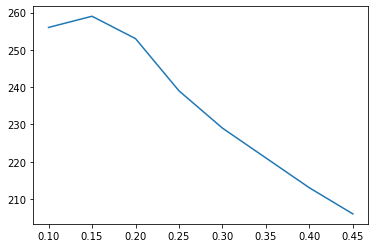

In [95]:
plt.plot(np.arange(0.1, 0.5, 0.05), r)

In [66]:
def gurobi_solve_with_init(items_weights, res_ff):
    model = gp.Model('bin packing problem')
    model.setParam('TimeLimit', 60)
    x = model.addVars(items_num, items_num, vtype = GRB.BINARY)
    y = model.addVars(items_num, vtype=GRB.BINARY)

    model.addConstrs((gp.quicksum([items_weights[i] * x[i,j] for i in range(items_num)])<=1 for j in range(items_num) ), name='container <=1')
    model.addConstrs((x.sum('*', i) <= y[i] * items_num for i in range(items_num)), name='indicator')
    model.addConstrs((x.sum(i, '*') == 1 for i in range(items_num)))

    model.setObjective(gp.quicksum(y), GRB.MINIMIZE)
    model.update()
    
    for i in range(items_num):
        for j in range(items_num):
            x[i,j].Start=0

    for c_id in range(len(res_ff)):
        for item_id in res_ff[c_id]:
            x[item_id, c_id].Start = 1
    model.update()
    model.optimize()
    
    
    return model.objVal, model.objBound
    
def gurobi_solve(items_weights):
    model = gp.Model('bin packing problem')
    model.setParam('TimeLimit', 60)
    x = model.addVars(items_num, items_num, vtype = GRB.BINARY)
    y = model.addVars(items_num, vtype=GRB.BINARY)

    model.addConstrs((gp.quicksum([items_weights[i] * x[i,j] for i in range(items_num)])<=1 for j in range(items_num) ), name='container <=1')
    model.addConstrs((x.sum('*', i) <= y[i] * items_num for i in range(items_num)), name='indicator')
    model.addConstrs((x.sum(i, '*') == 1 for i in range(items_num)))

    model.setObjective(gp.quicksum(y), GRB.MINIMIZE)
    model.update()
    model.optimize()
    
    return model.objVal, model.objBound
    

In [18]:
def Martello_Toth_LB(items):
    alpha = 0.3
    L1 = []
    L2 = []
    L3 = []
    for i in items:
        if i>1-alpha:
            L1.append(i)
        elif i > 1/2:
            L2.append(i)
        elif i >= alpha:
            L3.append(i)
    H = len(L1) + len(L2) + max(0, np.ceil(sum(L3) - (len(L2) - sum(L2))))
    return H

In [97]:
import time
next_fit_res = []
first_fit_res = []
next_k_fit_res = []
worst_fit_res = []
fernandez_alg_res = []
gurobi_res = []
gurobi_init_res = []

ff_time = []
next_time = []
next_k_time = []
wf_time = []
fern_time = []
gurobi_time = []
gurobi_init_time = []

gurobi_LB = []
gurobi_init_LB = []
mart_LB = []


test_cases = [25, 50, 100, 250, 500, 750, 1000]

for i in test_cases[:]:
    items_num = i
    items_weights = np.random.random(items_num)
    
    a = time.time()
    res_ff = first_fit_1d(items_weights)
    b = time.time()
    ff_time.append(b-a)
    first_fit_res.append(len(res_ff))
    
    a = time.time()
    next_fit_res.append(len(next_fit_1d(items_weights)))
    b = time.time()
    next_time.append(b-a)
    
    a = time.time()
    next_k_fit_res.append(len(next_k_fit_1d(items_weights, k=3)))
    b = time.time()
    next_k_time.append(b-a)
    
    a = time.time()
    worst_fit_res.append(len(worst_fit(items_weights)))
    b = time.time()
    wf_time.append(b-a)
    
    a = time.time()
    s, lb = gurobi_solve(items_weights)
    gurobi_res.append(s)
    gurobi_LB.append(lb)
    b = time.time()
    gurobi_time.append(b-a)
    
    a = time.time()
    s, lb = gurobi_solve_with_init(items_weights, res_ff)
    gurobi_init_res.append(s)
    gurobi_init_LB.append(lb)
    b = time.time()
    gurobi_init_time.append(b-a)
    
    mart_LB.append(Martello_Toth_LB(items_weights))
    
    
    

Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 75 rows, 650 columns and 1900 nonzeros
Model fingerprint: 0x15622827
Variable types: 0 continuous, 650 integer (650 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 20.0000000
Presolve time: 0.02s
Presolved: 75 rows, 650 columns, 1900 nonzeros
Variable types: 0 continuous, 650 integer (650 binary)

Root relaxation: objective 2.777778e+00, 126 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.77778    0   16   20.00000    2.77778  86.1%     -    0s
H  

     0     0   13.37841    0   67   21.00000   13.37841  36.3%     -    1s
     0     0   13.37841    0   73   21.00000   13.37841  36.3%     -    1s
     0     0   13.75408    0   71   21.00000   13.75408  34.5%     -    1s
     0     0   14.12683    0   74   21.00000   14.12683  32.7%     -    1s
     0     0   14.12683    0   65   21.00000   14.12683  32.7%     -    1s
     0     2   14.12683    0   65   21.00000   14.12683  32.7%     -    1s

Cutting planes:
  Cover: 51
  Clique: 20
  MIR: 43
  StrongCG: 26
  Zero half: 1

Explored 17 nodes (4719 simplex iterations) in 1.79 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 21 22 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.100000000000e+01, best bound 2.100000000000e+01, gap 0.0000%
Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up t

Coefficient statistics:
  Matrix range     [5e-03, 3e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 188.0000000
Presolve time: 0.95s
Presolved: 750 rows, 62750 columns, 187750 nonzeros
Variable types: 0 continuous, 62750 integer (62750 binary)

Root relaxation: objective 1.190476e+01, 3925 iterations, 1.50 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.90476    0  278  188.00000   11.90476  93.7%     -    5s
H    0     0                     163.0000000   11.90476  92.7%     -    5s
H    0     0                     143.0000000   11.90476  91.7%     -    5s
H    0     0                     138.0000000   11.90476  91.4%     -   13s
     0     0   11.90476    0  374  138.00000   11.90476  91.4%     -   15s
H    0     0                     131.0000000   11.90476  90.9

Optimize a model with 2250 rows, 563250 columns and 1688250 nonzeros
Model fingerprint: 0x55816c36
Variable types: 0 continuous, 563250 integer (563250 binary)
Coefficient statistics:
  Matrix range     [5e-04, 8e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 584.0000000
Presolve removed 0 rows and 0 columns (presolve time = 8s) ...
Presolve time: 7.53s
Presolved: 2250 rows, 563250 columns, 1688250 nonzeros
Variable types: 0 continuous, 563250 integer (563250 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.500000e+02   0.000000e+00      9s
    2981    2.3626111e-04   2.744952e+03   0.000000e+00     10s
    5271    1.6741858e+01   6.732995e+03   0.000000e+00     15s
    7690    1.6741699e+01   0.000000e+00   0.000000e+00     17s

Root relaxation: objective 1.674170e+01, 7690 iterations, 8.90 seconds
Total elapsed time

In [98]:
import matplotlib.pyplot as plt

In [99]:
import pandas as pd

In [100]:
df = pd.DataFrame(index = test_cases)
df['nf'] = next_fit_res
df['ff'] = first_fit_res
df['next_k'] = next_k_fit_res
df['wf'] = worst_fit_res
df['gurobi'] = gurobi_res
df['gurobi_init'] = gurobi_init_res
df['gurobi_init_LB'] = gurobi_init_LB
df['gurobi_LB'] = gurobi_LB
df['Martello_LB'] = mart_LB


In [101]:
df

,nf,ff,next_k,wf,gurobi,gurobi_init,gurobi_init_LB,gurobi_LB,Martello_LB
25,15,14,14,14,13.0,13.0,13.0,13.0,13.0
50,27,22,25,25,21.0,21.0,21.0,21.0,20.0
100,66,57,60,59,53.0,53.0,51.0,51.0,51.0
250,165,133,146,146,129.0,130.0,116.0,110.0,122.0
500,342,276,307,303,306.0,273.0,16.0,16.0,261.0
750,508,414,465,453,584.0,414.0,17.0,17.0,398.0
1000,674,535,600,596,770.0,535.0,23.0,23.0,511.0


In [46]:
%%timeit
next_fit_1d(items_weights)

311 µs ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [49]:
%%timeit
first_fit_1d(items_weights)

1.08 s ± 45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
def time_test(func, iter_multiplier = 1):
    times = []
    for i in test_cases:
        items_num = i
        items_weights = np.random.random(items_num)
        a = time.time()
        for _ in range(10*iter_multiplier):
            func(items_weights)
        b = time.time()
        times.append((b-a)/10/iter_multiplier)
    return times

Text(0.5, 1.0, 'FF')

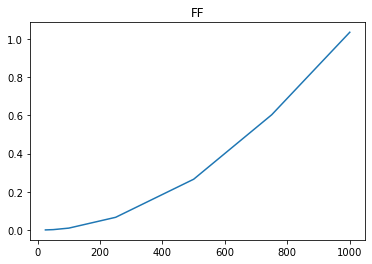

In [63]:
plt.plot(test_cases, time_test(first_fit_1d))
plt.title("FF")

Text(0.5, 1.0, 'NF')

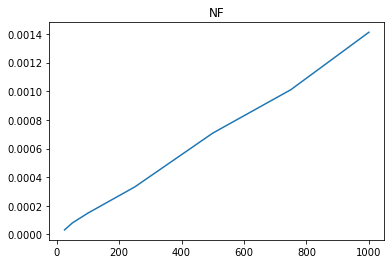

In [61]:
plt.plot(test_cases, time_test(next_fit_1d, 100))
plt.title('NF')

Text(0.5, 1.0, 'Next K fit')

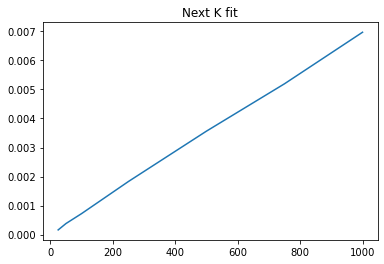

In [62]:
plt.plot(test_cases, time_test(next_k_fit_1d, 100))
plt.title('Next K fit')

Text(0.5, 1.0, 'WF')

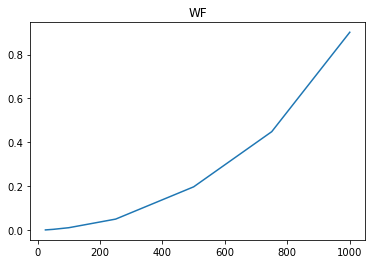

In [64]:
plt.plot(test_cases, time_test(worst_fit))
plt.title("WF")